# Red completa de Bogotá

Ya habiendo creado el archivo csv base para la realizacion de este trabajo, el siguiente paso es volver a crear las redes que ya habian sido creadas, pero en este caso, solo para los municipios de Bogotá y Soacha (Suachintown), hacer el respectivo estudio de la distribucuin de grado en la red no dirigida, el in_degree y out_degree de la red dirigida sin pesar, y la fuerza de cada nodo para el caso de la red pesada, con el numero de viajes en cada sentido (recordar que es el numero de viajes y no de personas como tal), se haran los respectivos ajustes a curvas exponenciales (dados los resultados del primer estudio) y se hara el estudio de clusterización y de ser necesario de cliques. En resumen, los estudios preeliminares de redes complejas. Se haran redes dependieno particularmente del estrato, medio de transporte y otros parametros que lo requieran y me diga Hurtado. 

In [1]:
# Importacion de las librerias necesarias 
import pandas as pd
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
import operator
import itertools
import datetime

from scipy.optimize import curve_fit

Se importa el archivo *Viajes_en_Bogota.csv* 

In [2]:
great_df = pd.read_csv('Viajes_en_Bogota.csv')
great_df

,Unnamed: 0,id_hogar,Estado,Utam,Sector,Seccion,Manzana,p5_fecha,p7_Barrio_vivienda,Latitud,...,p7_id_actividad_economica,p7v_lugar_inicio_dia,p8v_barrio_vereda,p9v_id_municipio,p9v_municipio,p10v_hora_salida,p11v_condujo_vehiculo,p13v_condujo_bicicleta,p15v_subsidio_SITP,Sexo
0,7089,17081,2,UTAM9,8534,3,14,2019-05-21,MIRADOR,4.761663,...,6.0,1.0,NaN,NaN,NaN,05:20:00,2.0,2.0,4.0,Hombre
1,7090,17081,2,UTAM9,8534,3,14,2019-05-21,MIRADOR,4.761663,...,6.0,1.0,NaN,NaN,NaN,05:20:00,2.0,2.0,4.0,Hombre
2,7091,17081,2,UTAM9,8534,3,14,2019-05-21,MIRADOR,4.761663,...,NaN,1.0,NaN,NaN,NaN,14:00:00,2.0,2.0,4.0,Mujer
3,7092,17081,2,UTAM9,8534,3,14,2019-05-21,MIRADOR,4.761663,...,NaN,1.0,NaN,NaN,NaN,14:00:00,2.0,2.0,4.0,Mujer
4,7096,P07096,1,UTAM9,8534,3,14,2019-05-21,MIRADOR DEL NORTE,4.761913,...,NaN,1.0,NaN,NaN,NaN,06:30:00,2.0,2.0,4.0,Mujer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105471,40322,P02949,1,UTAM570,20,5,8,2019-04-11,LA MARIA SOACHA,4.597883,...,NaN,1.0,NaN,NaN,NaN,06:05:00,2.0,2.0,4.0,Mujer
105472,40323,P02949,1,UTAM570,20,5,8,2019-04-11,LA MARIA SOACHA,4.597883,...,NaN,1.0,NaN,NaN,NaN,06:05:00,2.0,2.0,4.0,Mujer
105473,40324,P02949,1,UTAM570,20,5,8,2019-04-11,LA MARIA SOACHA,4.597883,...,NaN,1.0,NaN,NaN,NaN,06:05:00,2.0,2.0,4.0,Mujer
105474,40333,P02950,1,UTAM570,20,5,8,2019-04-11,LA MARIA SOACHA,4.597883,...,19.0,1.0,NaN,NaN,NaN,08:00:00,2.0,9.0,4.0,Mujer


Se separan las columnas zat_origen y zat_destino para poder hacer la red de movilidad 

In [3]:
df_red_adj = (great_df[['zat_origen','zat_destino']]
                    .sort_values(by = ['zat_origen','zat_destino'])
                    .dropna()
                    .reset_index())
df_red_adj['viajes'] = 1
df_red_adj = df_red_adj.drop(columns  = ['index'])
df_red_adj

,zat_origen,zat_destino,viajes
0,0.0,0.0,1
1,0.0,60.0,1
2,0.0,66.0,1
3,0.0,85.0,1
4,0.0,93.0,1
...,...,...,...
105471,1141.0,225.0,1
105472,1141.0,247.0,1
105473,1141.0,252.0,1
105474,1141.0,477.0,1


Hay un error a la hora de transformar las matrices de adyasencia en redes a partir de NetworkX, no existen las columnas 1061 y 959, lo sual quiere decir que nadie va hacia 1061 y 959, pero de la misma manera, no existen las filas 308 y 478, es decir, nadie sale de 308 y 478,por lo cual toca crear dichas filas y columnas para que la matriz se mantenga simetrica, pero para mantener la dirección, estas filas y columnas se llenaran de ceros. 

En el primer notebook la zona 959 presentaba problemas pero no la 1061, seguramente sea que alguien de otro municipio fuera de bogota llegaba a dicha zona, pero por el filtrado ya esa coneccion no existe.

In [4]:
# Creacion de la matriz de adyacencia pesada 
matrix_w = (df_red_adj.groupby(['zat_origen', 'zat_destino'], as_index = False)['viajes']
                     .agg('sum')
                     .pivot_table(values = ('viajes'), index = 'zat_origen', columns = 'zat_destino')
                     .fillna(0))
matrix_w[959] = 0
matrix_w[1061] = 0
matrix_w.loc[308] = 0
matrix_w.loc[478] = 0

In [5]:
# Creacion de la matriz de adyacencia sin pesar
matrix_unw = (df_red_adj.drop_duplicates()
                     .pivot_table(values = ('viajes'), index = 'zat_origen', columns = 'zat_destino')
                     .fillna(0))
matrix_unw[959] = 0
matrix_unw[1061] = 0
matrix_unw.loc[308] = 0
matrix_unw.loc[478] = 0

In [6]:
np.unique(great_df['mun_destino'].values)

array([11001., 25754.])

Ya con las matrices de adyacencia corregidas de manera satisfactoria, manteniendo la matriz cuadrada (como debe ser), ya se proceden a crear las redes pertinentes para empezar el analisis del problema, las cuales son, red simple sin pesar, red dirigida sin pesar, red pesada no dirigida y red pesada dirigida.

In [7]:
# Creacion de los grafos
und_unw_graph = nx.from_pandas_adjacency(matrix_unw)
d_unw_graph = nx.from_pandas_adjacency(matrix_unw, create_using = nx.DiGraph)
und_w_graph = nx.from_pandas_adjacency(matrix_w)
d_w_graph = nx.from_pandas_adjacency(matrix_w, create_using = nx.DiGraph)

## Una pequeña muestra del grafo de movilidad del conjunto Bogota Soacha no dirigido sin pesar


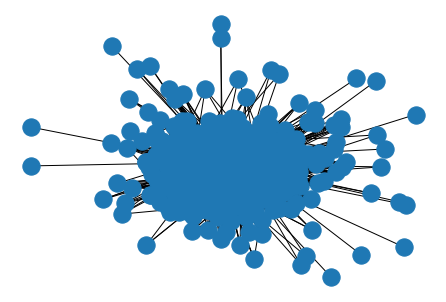

In [47]:
nx.draw(und_unw_graph)

## Funciones para grafos 

In [8]:
# Se define la funcion de distribucion del grado
def degree_dist(G):
    degree = dict(G.degree())
    values_x = sorted(set(degree.values()))
    dist_y = [list(degree.values()).count(x) for x in values_x]
    return values_x, dist_y

def in_out_degree(G):
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    in_x = sorted(set(in_degree.values()))
    out_x = sorted(set(out_degree.values()))
    in_y = [list(in_degree.values()).count(x) for x in in_x]
    out_y = [list(out_degree.values()).count(x) for x in out_x]
    return in_x, in_y, out_x, out_y

def mean_degree(G):
    degree = dict(G.degree())
    array = []
    for i in degree.values():
        array.append(i)
    array = np.asarray(array)
    return np.sum(array)/len(array)

# para fuerza in in_out = 0, para fuerza out in_out = 1, para fuerza en general in_out = 1, creeeooo
def nodal_strength(array, in_out):
    my_array = []
    for i in array:
        count = 0
        for j in array:
            if j[in_out] == i[in_out]:
                for k in j[2].values():
                    count = count +k
        my_array.append((count, i[in_out]))
    my_array = list(set(my_array))
    my_array.sort(reverse = True) 
    return my_array

# Funcion para completar las matrices de adyacencia y poder crear la red.
def what_index_columns(matrix):
    index = []
    columns = []
    for i in matrix.index:
        if i not in matrix.columns:
            columns.append(i)
    for i in matrix.columns:
        if i not in matrix.index:
            index.append(i)
    return index, columns

# Agrega las filas y columnas faltantes     
def index_columns(matrix, index, columns):
    for i in index:
        matrix.loc[i] = 0
    for j in columns:
        matrix[j] = 0
        
# Se calcula la densidad de una red 
def density(G):
    dn = 2*G.number_of_edges()/(len(G)**2-1)
    return dn

## Funciones del resto

In [177]:
# Se define una funcion exponencial para poder ajustar las curvas
def expo(x1, a, b):
    return a*np.exp(-b*x1)

# Se definde la ley de potencias 
def pow_law(x, a, b):
    return a*pow(x, -b)

# Funcion para el R^2
def r_squared(xdata, ydata, popt):
    residuals = ydata - expo(xdata, popt[0], popt[1])
    ss_res = np.sum(residuals**2.0)
    ss_tot = np.sum((ydata-np.mean(ydata))**2.0)
    r = 1 - (ss_res / ss_tot)
    return r

# Se define la funcion que cuenta cada elemento en un areglo
def count(array):
    y_dist = np.asarray([list(array).count(x) for x in np.unique(array)])
    x_dist = np.asarray([x for x in np.unique(array)])
    return x_dist, y_dist

# Cambia los datos de hora a tipo datatime 
def to_time(clmn):
    array = []
    for i in clmn:
        array.append(datetime.datetime.strptime(i, '%H:%M:%S').time())
    return array

# Funcion en la que se aplica el metodo de newman
def newman(array):
    my_array = []
    for i in range(len(array)):
        P = sum(array[i:])
        my_array.append(P)
    return my_array

### Grado y analisis de la red
En esta sección se analisan las principales cantidades del grafo simple, y tambien la distribución del grado, la cual es aporximadamente exponencial (a ojo).

In [157]:
x, y = degree_dist(und_unw_graph)
x = np.asarray(x)
y = np.asarray(y)
popt1, pcov1 = curve_fit(expo, xdata = x, ydata = y)
xspace = np.linspace(0,400, num = 400)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [166]:
sum(x[100:])

22826

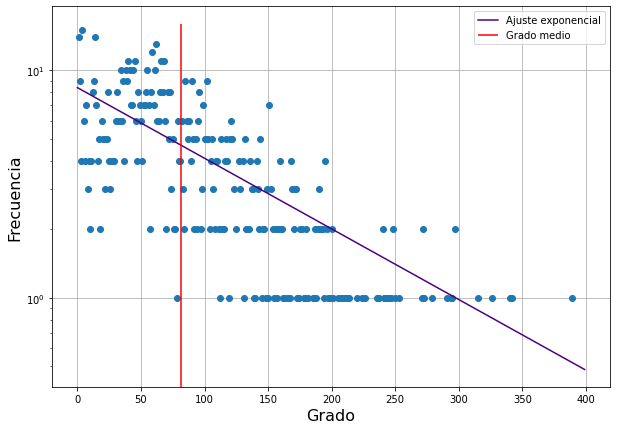

In [156]:
plt.figure(figsize = (10,7))
plt.semilogy(x, y, 'o')
plt.semilogy(expo(xspace,popt1[0], popt1[1]), color = 'indigo', label = 'Ajuste exponencial')
plt.vlines(mean_degree(und_unw_graph), 0, 16, color = 'r',label = 'Grado medio')
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [181]:
y_array = np.asarray(y)/sum(y)
popt2, pcov2 = curve_fit(expo, xdata = x, ydata = y_array)
y_newman = newman(y_array)
popt3, pocv3 = curve_fit(expo, xdata = x, ydata = y_newman)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [176]:
sum(y_array[100:])

0.30188679245283107

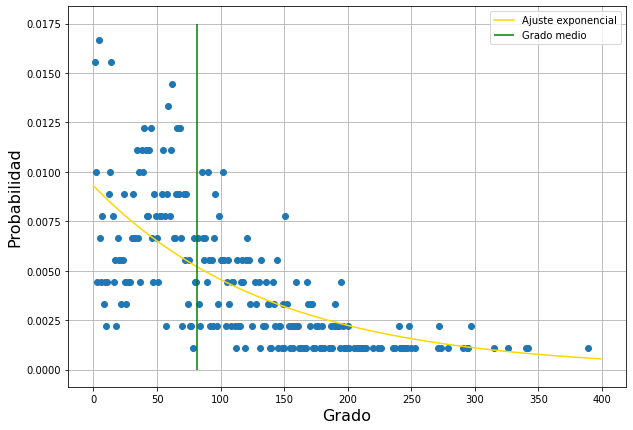

In [179]:
plt.figure(figsize = (10,7))
plt.plot(x, y_array, 'o')
plt.plot(expo(xspace,popt2[0], popt2[1]), color = 'gold', label = 'Ajuste exponencial')
plt.vlines(mean_degree(und_unw_graph), 0, 0.0175, color = 'g',label = 'Grado medio')
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Probabilidad', fontsize=16)
plt.legend()
plt.grid()
plt.show()

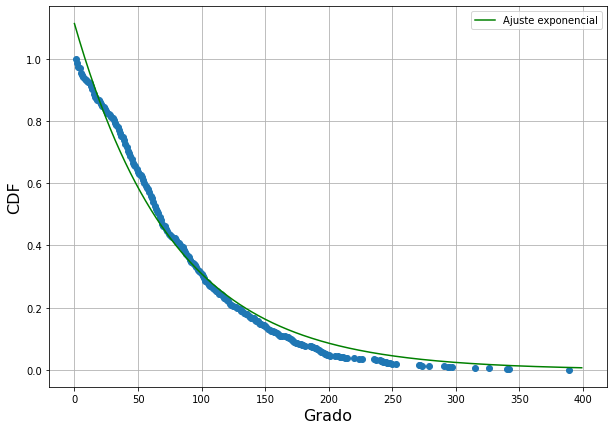

In [189]:
plt.figure(figsize = (10,7))
plt.plot(x, y_newman, 'o')
plt.plot(expo(xspace,popt3[0], popt3[1]), color = 'g', label = 'Ajuste exponencial')
#plt.vlines(mean_degree(und_unw_graph), 0, 0.0175, color = 'g',label = 'Grado medio')
plt.xlabel('Grado', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [183]:
# Calculo del R^2 para ambos casos 
print(r_squared(x, y, popt1))
print(r_squared(x, y_array, popt2))
print(r_squared(x, y_newman, popt3))

0.47062830470430184
0.470628304708136
0.9873748888513729


In [23]:
popt1

array([8.37624927e+00, 7.12266035e-03])

In [16]:
print(und_unw_graph.number_of_edges())
print(len(und_unw_graph))

36630
901


In [14]:
2*und_unw_graph.number_of_edges()/(len(und_unw_graph)*(len(und_unw_graph)-1))

0.09034406215316315

In [17]:
2*und_unw_graph.number_of_edges()/len(und_unw_graph)

81.30965593784684

In [20]:
nx.diameter(und_unw_graph)

4

Lo primero que toca hacer es describir la red. La red cuenta con un numero de nodos $n = 901$, los cuales cuentan con un total de $36630$ conecciones. El grafo cuenta con una densidad $\Delta = 0.09034406215316315$ la cual es baja, es decir que la red no esta muy conectada, lo cual tambien se puede ver en el valor del grado medio de $k_{mean} = 81.31$ es mas de diez veces menor al numero de nodos presentes en la red, se puede decir que en una primera aproximacion, cada nodo solo se conecta con un decimo del total de nodos en la red. Por otra parte, el diametro de la red (como lo supuse), es de $4$, pero este valor no es muy relevante ya que lo mas probable es que nadie viaje entre los dos lugares que esten separados por cuatro conecciones, esas zonas deben ser algo como un potrero en Suachintown y otro en Torca.

Depronto si el grafo se hiciera con zonificaciones mas grandes como UTAMS, este estaria mas interconectado.

Como se puede ver en las dos graficas, tanto de frecuencia como de probabilidad, paraciera ser (de una manera demasiado aproximada e intuitiva, por ahora no muy rigurosa) que estas siguen una ley exponencial. Claramente, para poder concluir esto se debe tener cierto tratamiento de los datos, pero de llegar a ser cierto, esto significaria que en esta curiosa situacion, hay alguna cantidad que se conserva en el sistema, la cuestion es, ¿cual?.

Como era de esperarse, para ambos casos, el de frecuencia y el de probabilidad, el $R^2$ da muy bajito (nos extraña? no nos extraña), el cual da un valor para ambos casos de $R^2 = 0.4706$, lo cual oooobviiaameeenteeee quiere decir que que no ajustan mucho, seguramente podria poner alguna curva tipo poission o lo que sea y el ajuste de mas que es el mismo, lo que de verdad toca hacer es ver si se puede hacer un histograma (bien hecho) que de razon del tipo de distribución.

Pooor fiiiiiiin con el metodo de Newman ya se puede decir con toda la seguridad que la distribucion del grado en Bogota y Soacha es una ley exponencial en donde con toda seguridad se conserva alguna cantidad. El ajuste exponencial de los datos tratados como Newman ($P = p(X > x)$) tiene un $R^2 = 0.9874$, lo cual quiere decir que es un muy buen ajuste.

In [19]:
# Zonas con mayor grado 
degree_dict = dict(und_unw_graph.degree())
sorted_d = dict( sorted(degree_dict.items(), key=operator.itemgetter(1),reverse=True))
dict_degree = dict(itertools.islice(sorted_d.items(), 10))
dict_degree

{276.0: 389,
 322.0: 342,
 275.0: 340,
 299.0: 326,
 354.0: 315,
 454.0: 297,
 997.0: 297,
 167.0: 295,
 456.0: 294,
 255.0: 291}

Aca se pueden ver cuales son las zonas (ZAT) con mayor grado en la ciudad. Dado que aun no se esta trabajando con la red pesada, no se puede decir que son las zonas a las que mas viaja la gente, lo que si se puede decir es que estan zonas que se conectan con mas zonas en la ciudad por medio de, a lo sumo, un viaje, es decir, personas de toda la ciudad viajan a estos lugares.

| Zat | Zona            | Grado |
|-----|-----------------|-------|
| 276 | Marly           | 389   |
| 322 | Salitre         | 342   |
| 275 | Hippies         | 340   |
| 299 | Jardin botanico | 326   |
| 354 | U Tadeo         | 315   |
| 454 | ASAB            | 297   |
| 997 | Fiscalia        | 297   |
| 167 | La Castellana   | 295   |
| 456 | Museo del oro   | 294   |
| 255 | Lourdes         | 291   |

Aca se pueden ver particularmente tres grupos en especifico que se conecten por medio de viajes con el resto de la ciudad, y estos son __Chapinero central__, __Salitre__ y __El centro__, junto con la castellana. Todo el pentagono entre la calle 65, calle 45, carreras 7 y avenida caracas presentan un grado altisimo. Al igual que la zona del centro comprendida por la calle 26, Jimenez, carrera 3 y 7, junto con la zona que rodea la carrera 13 por la plaza de san victorino. La zona salitre esta comprendida por la avenida La Esperanza desde el bunquer hasta la avenida Rojas, cruza la 26 e incluye el area del Jardin botanico. 

Algo que se puede resaltar es la importancia de la carrera 13 como eje de "simetria" para una de estas agrupaciones, con suma importancia tambien en la zona __Centro__.

Uno puede hacerse la imagen de que estas tres zonas estan organizadas por los ejes dados por dos grandes avenidas, la 26 y la caracas.

### Grado in y out de la red dirigida

In [10]:
x_in, y_in, x_out, y_out = in_out_degree(d_unw_graph)

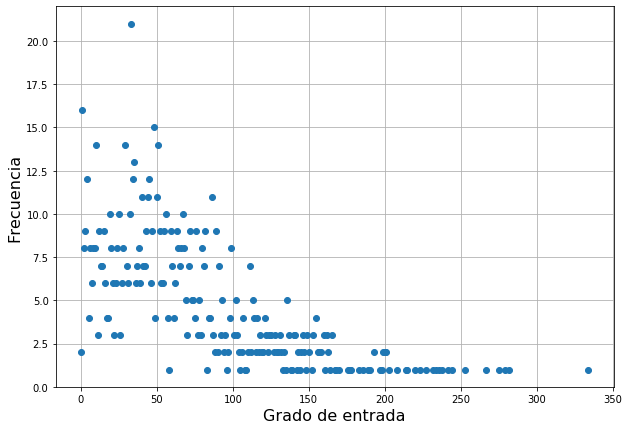

In [11]:
plt.figure(figsize = (10,7))
plt.plot(x_in, y_in, 'o')
#plt.plot(x_out, y_out, 'p')
#plt.vlines(mean_degree(und_unw_graph), 0, 16, color = 'r',label = 'Grado medio')
plt.xlabel('Grado de entrada', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
#plt.legend()
plt.grid()
plt.show()

Parece ser que el grado de entrada se comporta aun mejor como ley exponencial.

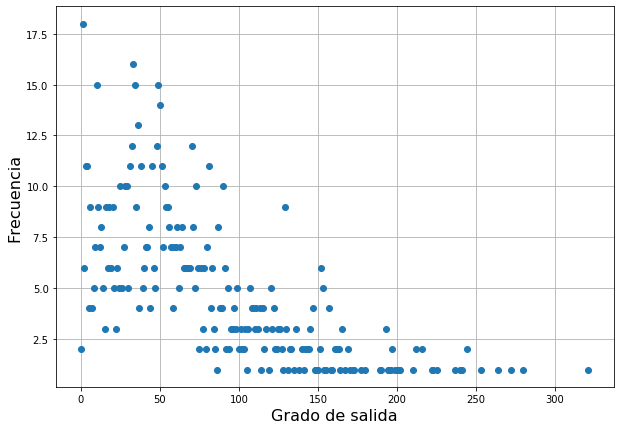

In [12]:
plt.figure(figsize = (10,7))
plt.plot(x_out, y_out, 'o')
#plt.plot(x_out, y_out, 'p')
#plt.vlines(mean_degree(und_unw_graph), 0, 16, color = 'r',label = 'Grado medio')
plt.xlabel('Grado de salida', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
#plt.legend()
plt.grid()
plt.show()

Ya el grado de salida se comporta mas raro, incluso parece no comportarse como una ley de potencias, lo cual es interesante pero me puede joder la vida.

Lo que se realizo a continuacion es un mero intento por ver algun tipo de correlacin entre las frecuencias de entrada y de salida, por mero desparche, pero esto seguramente debe hacerse con mucho mas cuidado. 

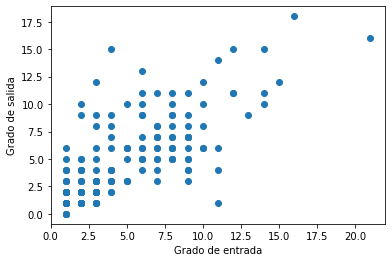

In [14]:
y_exp = y_out+[0,0,0,0]
plt.plot(y_in, y_exp, 'o')
plt.xlabel('Grado de entrada')
plt.ylabel('Grado de salida')
plt.show()

El siguiente paso a realizar es el de ver de donde salen y hacia donde van mas personas, lo cual seguramente sera muy parecido al caso del grafo sin pesar, pero podemos llevarnos varias sorpresas.

In [66]:
# Zonas con mayor grado 
degree_dict_in = dict(d_unw_graph.in_degree())
degree_dict_out = dict(d_unw_graph.out_degree())
sorted_in = dict( sorted(degree_dict_in.items(), key=operator.itemgetter(1),reverse=True))
sorted_out = dict( sorted(degree_dict_out.items(), key=operator.itemgetter(1),reverse=True))

dict_in = dict(itertools.islice(sorted_in.items(), 10))
dict_out = dict(itertools.islice(sorted_out.items(), 10))

print(dict_in, '\t', dict_out, '\t', dict_degree)

{276.0: 334, 322.0: 282, 275.0: 279, 299.0: 275, 354.0: 267, 997.0: 253, 167.0: 244, 255.0: 242, 454.0: 238, 456.0: 236} 	 {276.0: 321, 322.0: 280, 275.0: 272, 354.0: 264, 299.0: 253, 255.0: 244, 456.0: 244, 167.0: 241, 997.0: 240, 454.0: 237} 	 {276.0: 389, 322.0: 342, 275.0: 340, 299.0: 326, 354.0: 315, 454.0: 297, 997.0: 297, 167.0: 295, 456.0: 294, 255.0: 291}


In [71]:
for i in dict_out.keys():
    #if i in dict_degree.keys():
    print(i)

276.0
322.0
275.0
354.0
299.0
255.0
456.0
167.0
997.0
454.0


Como se puede ver en los anteriores codigos, tanto para el grado de entrada como el de salida, se conservan las mismas zonas para el caso de el grafo no dirigido.

### Clusterizacion

Aca se va a calcular la distribucion para el indice de clusterizacion en la red simple sin pesar.

In [13]:
def cluster_dist(G):
    cluster = nx.clustering(G).values()
    cluster_x = sorted(set(cluster))
    cluster_y = [list(cluster).count(x) for x in cluster_x]
    #hist = [list(bog.values()).count(x) for x in values]
    return cluster_x, cluster_y

In [75]:
clust_x, clust_y = cluster_dist(und_unw_graph)

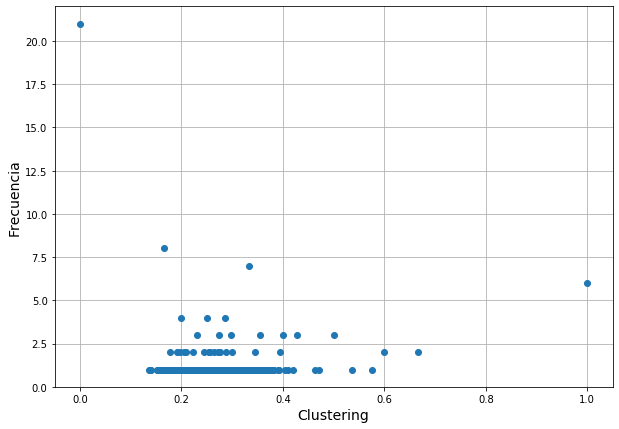

In [77]:
plt.figure(figsize = (10,7))
plt.plot(clust_x, clust_y, 'o')
plt.xlabel('Clustering', fontsize = 14)
plt.ylabel('Frecuencia', fontsize = 14)
plt.grid()
plt.show()

In [91]:
nx.average_clustering(und_unw_graph)

0.26208088454731154

In [14]:
cluster = nx.clustering(und_unw_graph)
degree_dict = dict(und_unw_graph.degree())
sorted_c = dict( sorted(cluster.items(), key=operator.itemgetter(1),reverse=True))
dict_cluster = dict(itertools.islice(sorted_c.items(), 10))
dict_cluster

{790.0: 1.0,
 84.0: 1.0,
 268.0: 1.0,
 797.0: 1.0,
 1040.0: 1.0,
 1052.0: 1.0,
 763.0: 0.6666666666666666,
 770.0: 0.6666666666666666,
 43.0: 0.6,
 789.0: 0.6}

Como se puede notar, el clustering promedio de toda la red es de $0.262$, lo cual significa que en promedio, si dos zonas estan conectadas y uno de estos esta conectado a otro, hay mas o menos una probabilidad de 0.26 de que los  otros dos esten conectados.

Como se puede ver en la grafica de fecuencia de clustering, hay com unos seis nodos en los cuales el clustering es 1, lo cual muestra una subestructura totalmente conectada, posteriormente se verificara cuales zonas componen esa estructura interna.

Como se puede ver, existe un conjunto de seis zonas cuyo indice de clusterizacion es de 1, vamos a ver cuales son.
Es algo bastante extraño este fenomeno de clusterizacion dado que son zonas que uno no pensaria de esa manera, van desde la casa de Duque, la parte de atras del parque nacional y Quiba alta en ciudad bolivar, las otras tres zonas no estan en la base de datos, lo cual me hace repensar el filtrado de datos o encontrar una mejor base de datos de la que yo cuento.
Un patron interesante que siguen las diez zonas con mayor clusterizacion es que todas son zonas pocos pobladas de los cerros orientales. Por debajo de los que tienen clusterizacion 1, estan otras zonas que cumplen mas o mens con la descripcion dada anteriorente, zonas alejadas y poco pobladas de los cerros, como la zona despejada despues de Casablanca en Suba y la ciudadela de Colsubsidio en la autopista sur saliendo de suacha. 

In [43]:
for i in und_unw_graph.degree():
    if i[0] == 789:
        print(i)

(789.0, 6)


In [51]:
for i in und_unw_graph.edges():
    if 763 in i:
        print(i)

(763.0, 761.0)
(763.0, 735.0)
(763.0, 1001.0)
(763.0, 725.0)


En el anterior codigo se buscó cual es el grado de cada una de estas zonas, las de clustering 1 tenian un grado de 2, y a medida que uno bajaba dicho grado iba aumentando, seria interesante ver cuales son las conecciones que tiene cada uno de estos nodos (al menos los que se pueden ubicar).

Las conexiones que presentan dichos nodos de clusterizacion 1 son muy raros y me hacen pensar en lo bien que estan tratados los datos y me genera preocupacion sobre los numeros de las ZAT.

### Analisis de la red pesada

In [14]:
print(dict(itertools.islice(dict(und_w_graph.degree()).items(), 20)))
print(dict(itertools.islice(dict(und_unw_graph.degree()).items(), 20)))

{0: 175, 1: 7, 2: 2, 3: 4, 4: 40, 945.0: 39, 932.0: 159, 798.0: 5, 790.0: 2, 767.0: 61, 763.0: 4, 740.0: 73, 737.0: 7, 716.0: 67, 714.0: 52, 694.0: 54, 692.0: 48, 987.0: 89, 676.0: 12, 674.0: 59}
{0: 175, 1: 7, 2: 2, 3: 4, 4: 40, 945.0: 39, 932.0: 159, 798.0: 5, 790.0: 2, 767.0: 61, 763.0: 4, 740.0: 73, 737.0: 7, 716.0: 67, 714.0: 52, 694.0: 54, 692.0: 48, 987.0: 89, 676.0: 12, 674.0: 59}


In [118]:
# Se aisla el valor de cada coneccion en la red
w_array = list(und_w_graph.edges(data = True)) 

Lo que tocara hacer es sacar la fuerza a punta de pandas porque no di como hacerlo con networkx

In [134]:
# Dataframe en donde se muestra de donde salen mas viajes 
df_w_out = (df_red_adj.groupby('zat_origen')['viajes']
                     .sum()
                     .reset_index()
                     .rename(columns = {'viajes':'w_out'})
                     .sort_values(by = ['w_out'], ascending = False))
df_w_out.head(10)

,zat_origen,w_out
314,322.0,607
269,276.0,606
755,782.0,560
519,530.0,554
346,354.0,524
268,275.0,509
850,1001.0,495
545,557.0,493
847,997.0,492
309,317.0,483


In [135]:
# Dataframe hacia donde llegan mas viajes 
df_w_in = (df_red_adj.groupby('zat_destino')['viajes']
                     .sum()
                     .reset_index()
                     .rename(columns = {'viajes':'w_in'})
                     .sort_values(by = ['w_in'], ascending = False))
df_w_in.head(10)

,zat_destino,w_in
269,276.0,622
315,322.0,617
757,782.0,555
521,530.0,538
347,354.0,522
268,275.0,515
805,951.0,502
851,1001.0,495
848,997.0,493
547,557.0,486


In [136]:
x_in, y_in = count(np.asarray(df_w_in['w_in']))
x_out, y_out = count(np.asarray(df_w_out['w_out']))
str_in_mean = np.mean(np.asarray(df_w_in['w_in']))
str_out_mean = np.mean(np.asarray(df_w_out['w_out']))
print(str_out_mean)
print(str_in_mean)

117.32591768631814
117.32591768631814


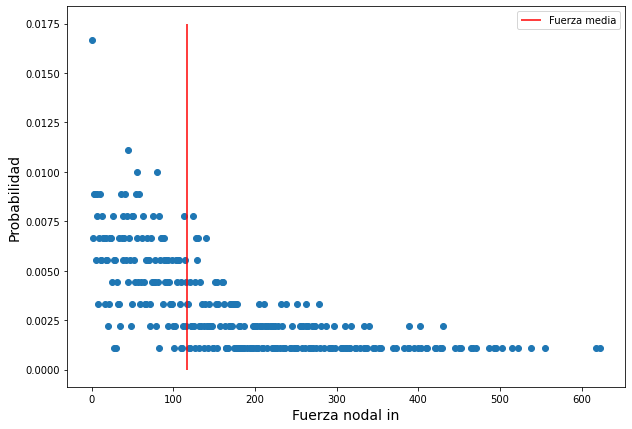

In [15]:
# Distribucion de probabilidad de la fuerza nodal in 
plt.figure(figsize = (10,7))
plt.plot(x_in, y_in/sum(y_in), 'o')
plt.vlines(str_in_mean, 0, 0.0175, color = 'r',label = 'Fuerza media')
plt.xlabel('Fuerza nodal in', fontsize = 14)
plt.ylabel('Probabilidad', fontsize = 14)
plt.legend()

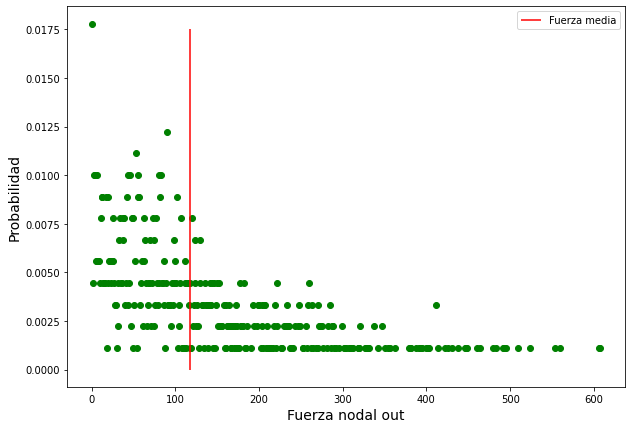

In [17]:
# Distribucion de probabilidad de la fuerza nodal out 
plt.figure(figsize = (10,7))
plt.plot(x_out, y_out/sum(y_out), 'o', color = 'g')
plt.vlines(str_in_mean, 0, 0.0175, color = 'r',label = 'Fuerza media')
plt.xlabel('Fuerza nodal out', fontsize = 14)
plt.ylabel('Probabilidad', fontsize = 14)
plt.legend()

Pooooor fiiiiiiin hice el carajo estudio de la fuerza de los nodos. En su gran mayoria se mantiene el conjunto de los nodos con mayor grado, como lo es Marly, Salitre, Hippies, peeeroooooo se juntan zonas nuevas tanto de salida como de llegada. De salida los tres primeros lugares de donde salen viajes son Salitre, Marly y la autopista sur por la via que viene de Indumil. Tambien aparecen zonas como el portal americas y Bosa al final de la avenida Bosa XD y curiosamente al frente de hayuelos.

Para el caso de la entrada a los nodos, mas o menos se conserva el conjunto de entrada a excepcion de la zona de mundo aventura (Cuadra picha XD).

Como se puede notar, excisten ciertas similaridades con el conjunto de nodos con mayor grado, pero no totalmente, como se puede notar, aparecen zonas que toca ver que grado tienen, pero salen y entran bastantes personas, en particular del portal de las americas, Bosa y Suachintown, que son de las zonas mas densamente pobladas en el area urbana. 

A manera de comentario se puede decir que efectivamente el metro se mueve por las zonas por donde viaja mas gente en su gran mayoria, pero tambien con una gran alerta hacai soacha, esta tiene la tercera zona por por la cual se hacen mas viajes y ni siquiera llega el transmilenio alla, mostrando de una manera simple la gran necesidad de este municipio por un transporte eficiente.

In [20]:
df_links = (df_red_adj.groupby(['zat_origen', 'zat_destino'], as_index = False)['viajes']
                      .sum()
                      .rename(columns = {'viajes':'links'})
                      .sort_values(by = ['links'], ascending = False))
x_link, y_link = count(np.asarray(df_links['links']))
w_links_mean = np.mean(np.asarray(df_links['links']))

In [17]:
popt3, pcov3 = curve_fit(pow_law, xdata = x_link, ydata = y_link)
xspace = np.linspace(0.7,max(x_link), num = max(x_link))

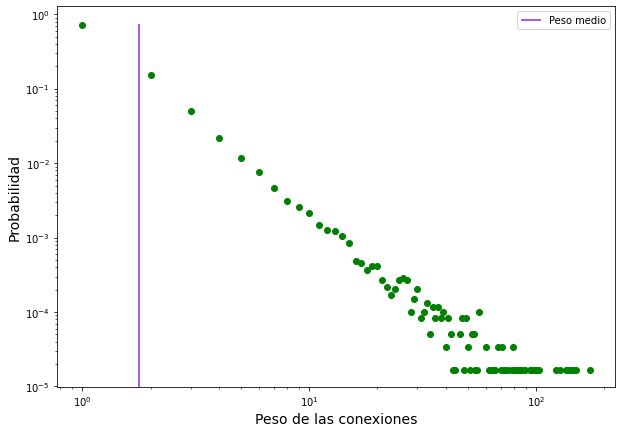

In [18]:
# Distribucion de probabilidad del peso de las conecciones en la red
plt.figure(figsize = (10,7))
plt.loglog(x_link, y_link/sum(y_link), 'o', color = 'g')
#plt.loglog(pow_law(xspace,popt3[0], popt3[1]), color = 'b', label = 'Ajuste ley de potencia')
plt.vlines(w_links_mean, 0, 0.75, color = 'blueviolet',label = 'Peso medio')
plt.xlabel('Peso de las conexiones', fontsize = 14)
plt.ylabel('Probabilidad', fontsize = 14)
plt.legend()

Esta es definitivamente la mejor grafica que he tenido en toda la tesis :v, pero no esta ajustando bien a una ley de potencias, lo cual es bastante raro y me preocuopa un poco, lo que creo que podria estar pasadno es queno puedo definir la ley de potencias asi tan a la ligera y tambien seguir el proceso que sugiere newman en su articulo de leyes de potencia.
Se encontro que el peso medio de las conecciones en la red es de 1.77, lo cual quiere decir que matar las conecciones desolo uno y considerar solo conecciones por encima de la media es la misma joda (dos pajaros de un solo tiro).

A partir de este df_liks se pueden crear las otras redes en donde el peso de las conecciones es mayor a 1 de manera facil, seria hacer el pivot_table y sale.

Excisten muuuchiiisimaaas conexiones que son bucles :( entonces tocara bajarse de dichas conexiones y ver que pasa con todas las cosas que he hecho.

La parte de la grafica tal ves se solucione con la propuesta de Newman.

In [21]:
df_links['viajes'] = 1

In [37]:
df_links[df_links['links'] > 1].head()

,zat_origen,zat_destino,links,viajes
58274,1001.0,1001.0,172,1
54918,932.0,932.0,150,1
40562,542.0,542.0,145,1
41733,557.0,557.0,142,1
52449,777.0,777.0,138,1


### Filtrado 

En esta parte del trabajo se mocharon todas las conecciones cuyo peso es uno, lo cual coincide a ser por encima del promedio XD, y se analisan las propiedades estructurales de este nuevo grafo.

In [22]:
# Matris de adyacencia sin pesar de la red con conecciones > 1
matrix_unw_w1 = (df_links[df_links['links'] > 1]
                     .pivot_table(values = ('viajes'), index = 'zat_origen', columns = 'zat_destino')
                     .fillna(0))
matrix_unw_w1[959] = 0
matrix_unw_w1[1061] = 0
matrix_unw_w1.loc[308] = 0
matrix_unw_w1.loc[478] = 0   

In [23]:
# Matris de adyacencia pesada de la red con conecciones > 1
matrix_w_w1 = (df_links[df_links['links'] > 1]
                     .pivot_table(values = ('links'), index = 'zat_origen', columns = 'zat_destino')
                     .fillna(0))
matrix_w_w1[959] = 0
matrix_w_w1[1061] = 0
matrix_w_w1.loc[308] = 0
matrix_w_w1.loc[478] = 0

In [24]:
# Funcion para ver que filas y columnas faltan 
index = []
columns = []
for i in matrix_unw_w1.index:
    if i not in matrix_w_w1.columns:
        columns.append(i)
for i in matrix_unw_w1.columns:
    if i not in matrix_w_w1.index:
        index.append(i)
def index_columns(matrix, index, columns):
    for i in index:
        matrix.loc[i] = 0
    for j in columns:
        matrix[j] = 0

index_columns(matrix_unw_w1, index, columns)
index_columns(matrix_w_w1, index, columns)

In [25]:
# Construccion de las redes 
und_unw_graph_w1 = nx.from_pandas_adjacency(matrix_unw_w1)
d_unw_graph_w1 = nx.from_pandas_adjacency(matrix_unw_w1, create_using = nx.DiGraph)
und_w_graph_w1 = nx.from_pandas_adjacency(matrix_w_w1)
d_w_graph_w1 = nx.from_pandas_adjacency(matrix_w_w1, create_using = nx.DiGraph)

In [26]:
# Nodos aislados
print(list(nx.isolates(und_unw_graph_w1)))
print(list(nx.isolates(d_unw_graph_w1)))
print(list(nx.isolates(und_w_graph_w1)))
print(list(nx.isolates(d_w_graph_w1)))

und_unw_graph_w1.remove_nodes_from(list(nx.isolates(und_unw_graph_w1)))
d_unw_graph_w1.remove_nodes_from(list(nx.isolates(d_unw_graph_w1)))
und_w_graph_w1.remove_nodes_from(list(nx.isolates(und_w_graph_w1)))
d_w_graph_w1.remove_nodes_from(list(nx.isolates(d_w_graph_w1)))

[959.0, 478.0, 308.0, 1061.0]
[959.0, 478.0, 308.0, 1061.0]
[959.0, 478.0, 308.0, 1061.0]
[959.0, 478.0, 308.0, 1061.0]


Los nodos que quedaron aislados son de zonas dondeliteral no hay nada XD, uno es por el humedal torca, el centro deportivo de la uniandes y un potrero al pie del aeropuerto cerca a la 13.

Lo que se va a hacer a continuacion es ver las propiedades primordiales de la red y ver esta joa como cambio

In [27]:
# Propiedades de la red
nodes = len(und_unw_graph_w1)
edges = und_unw_graph_w1.number_of_edges()
rho = 2*edges/((nodes*nodes)-1)
k_mean = 2*edges/nodes
#diameter = nx.diameter(und_unw_graph_w1)
print(nodes)
print(edges)
print(rho)
print(k_mean)
#print(diameter)

850
10159
0.028121838230917965
23.903529411764705


Caaaaraaajoooooooo esta red cambio totalmente :o
Psamos de tener $n = 901$ nodos a tener $n = 850$, las conecciones pasaron de ser $36630$ a $10159$, menos de un tercio de esa cantidad, es decir, esta red tiene mas o menos el 30% de las conecciones originales, el grado medio ahora tiene un vaor $k_{mean} = 23.9$, cuando antes esta tenia un valor de $81.31$, y la densidad antes era de $0.09034406215316315$, ahora es $\Delta = 0.028121838230917965$, lo cual quiere decir que la red sin las conecciones con un solo viaje es un poco mas de tres veces menos densa, en concordancia con la proporcion entre cantidad de conecciones y densidad. 
En terminos practicos, ahora tenemos una red muchisimo menos densa que la original, toca ver como es la estructura de esta nueva red a partir del grado.

Analisis del grado de esta red

In [28]:
x1, y1 = degree_dist(und_unw_graph_w1)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
popt_1, pcov_1 = curve_fit(expo, xdata = x1, ydata = y1)
xspace = np.linspace(0,180, num = 180)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


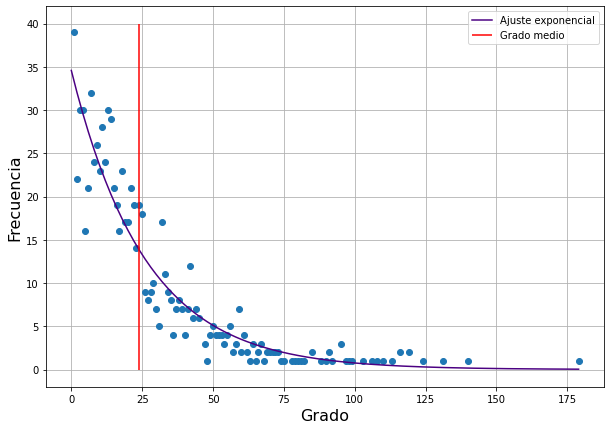

In [29]:
plt.figure(figsize = (10,7))
plt.plot(x1, y1, 'o')
plt.plot(expo(xspace,popt_1[0], popt_1[1]), color = 'indigo', label = 'Ajuste exponencial')
plt.vlines(k_mean, 0, 40, color = 'r',label = 'Grado medio')
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [136]:
y_array1 = y1/sum(y1)
popt2_1, pcov2_1 = curve_fit(expo, xdata = x1, ydata = y_array1)

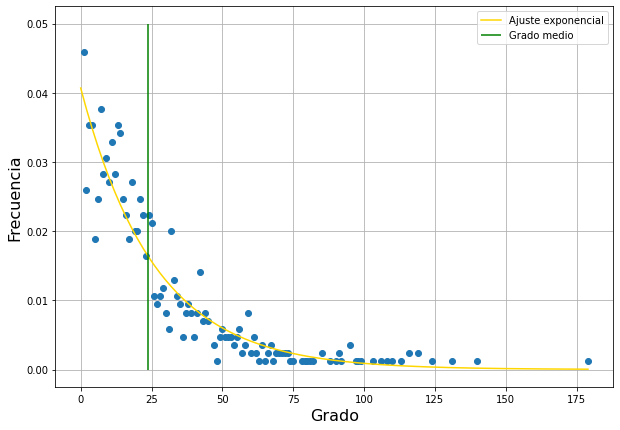

In [138]:
plt.figure(figsize = (10,7))
plt.plot(x1, y_array1, 'o')
plt.plot(expo(xspace,popt2_1[0], popt2_1[1]), color = 'gold', label = 'Ajuste exponencial')
plt.vlines(k_mean, 0, 0.05, color = 'g',label = 'Grado medio')
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [130]:
print(r_squared(x1, y_array1, popt2_1))

0.8877874225836623


Ahora si se puede decir con mas seguridad que la estructura que sigue la ciudad es la de una ley exponencial en donde definitvamente debe existir una cantidad conservada, quepara estos casos es $\beta$ en el exponente de la distribucion $\alpha e^{-\beta x}$. El ajuste dio de manera muchisimo mas satisfactoria que la primera red, con un $R^2 = 0.8888$, lo cual ya da mas argumentos de peso para decir que la estructura del transporte en la ciudad sigue una ley exponencial, ya lo que toca hacer a continuacion es aplicar el metodo de newman para estar aun mas seguros de que la joda es exponencial.

Algo que toca resaltar es que, al eliminar las conecciones con una sola persona, la distribucion si cambio bastante, la forma incluso mejoro pero por ejemplo, ahora el grado maximo es de $179$, mientras que antes era de $389$, se redujo casi a la mitad, mostrando que al menos la mitad de las conecciones de Marly eran de un solo viaje, pero se muestra el papel primordial de esta zona, porque perdio tan solo la mitad de las conecciones, no un tercio, como fue el comportamiento global de la red, de hecho, este comportamiento se mantiene en todas las zonas con mayor grado. Por otra parte las frecencias tambien cambiaron bastante, ahora hay mas ZATs con un grado $k = 1$, mientras que antes la distribucion tendia a "achatarse" mas, no se si sea correcto pero estas conecciones de un solo viaje podria decirse que eran "ruido" aunque no se si sea correcto pero es una hipotesis.

In [30]:
# Zonas de mayor grado 
degree_dict_w1 = dict(und_unw_graph_w1.degree())
sorted_d_w1 = dict( sorted(degree_dict_w1.items(), key=operator.itemgetter(1),reverse=True))
dict_degree_w1 = dict(itertools.islice(sorted_d_w1.items(), 10))
dict_degree_w1

{276.0: 179,
 322.0: 140,
 275.0: 131,
 299.0: 124,
 454.0: 119,
 997.0: 119,
 354.0: 116,
 255.0: 116,
 951.0: 113,
 456.0: 110}

Ahora no voy a hacer la tabla pero las zonas con mayor grado se mantienen, las aglomeraciones que se comentaron en el primer resultado se mantienen, lo que son Chapinero central, Salitre y el centro aun estan presentes, cambiaron un poco su orden pero ahi estan, pero algo que si cambio es que la candelaria ya no esta entre las 10 primeras zonas de mayor grado, si no que fue desplazada por la zona de Mundo Aventura (cuadra picha XD).

In [151]:
x1_in, y1_in, x1_out, y1_out = in_out_degree(d_unw_graph_w1)
popt_in, pcov_in = curve_fit(expo, xdata = x1_in, ydata = y1_in)
popt_out, pcov_out = curve_fit(expo, xdata = x1_out, ydata = y1_out)
xspace_in_out = np.linspace(0,150, num = 150)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


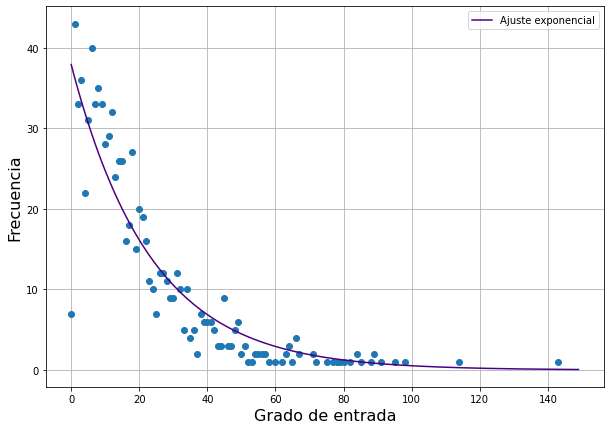

In [152]:
plt.figure(figsize = (10, 7))
plt.plot(x1_in, y1_in, 'o')
plt.plot(expo(xspace_in_out,popt_in[0], popt_in[1]), color = 'indigo', label = 'Ajuste exponencial')
plt.xlabel('Grado de entrada', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
plt.legend()
plt.grid()
plt.show()

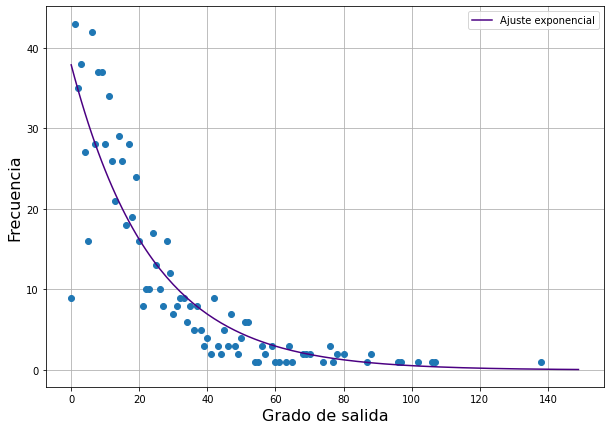

In [153]:
plt.figure(figsize = (10, 7))
plt.plot(x1_out, y1_out, 'o')
plt.plot(expo(xspace_in_out,popt_out[0], popt_out[1]), color = 'indigo', label = 'Ajuste exponencial')
plt.xlabel('Grado de salida', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [155]:
print(r_squared(np.asarray(x1_in), np.asarray(y1_in), popt_in))
print(r_squared(np.asarray(x1_out), np.asarray(y1_out), popt_out))

0.8210897337628497
0.7920684907373171


Aca tambien se puede notar que de manera mejor aproximada y con mas confianza que, estas dos distribuciones de grado siguen una ley exponencial al igual que la global, con unos valores de $R^2$ aceptables, pues todo es mejor a los $R^2$ que obtuve en las primeras grafica.

In [158]:
for i in y1_in:
    if i not in y1_out:
        print(i)

33
36
22
31
40
33
33
32
15
20
11
11


<function matplotlib.pyplot.show(close=None, block=None)>

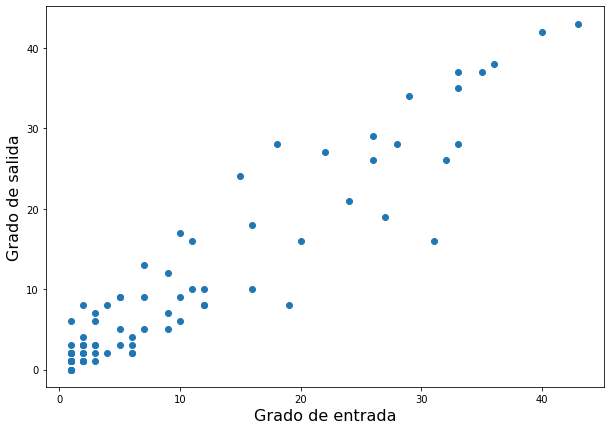

In [161]:
# Correlacion 
plt.figure(figsize = (10, 7))
plt.plot(y1_in, y1_out+[0,0,0,0], 'o')
plt.xlabel('Grado de entrada', fontsize=16)
plt.ylabel('Grado de salida', fontsize=16)
plt.show

Yo se que esta joda se hizo con las patadas y toca hacerla mejor peeeroooo se nota de una manera mas adecuada que se sigue una correlacion aproccimadamente lineal, tocaria rellenar bien el arreglo pero tiene buena pinta.

Hora de ver como cambio la clusterizacion

In [165]:
clust1_x, clust1_y = cluster_dist(und_unw_graph_w1)

<function matplotlib.pyplot.show(close=None, block=None)>

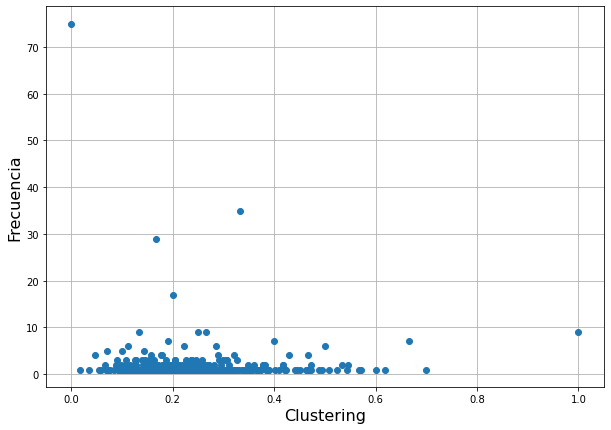

In [173]:
plt.figure(figsize = (10, 7))
plt.plot(clust1_x, clust1_y, 'o')
plt.xlabel('Clustering', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
plt.grid()
plt.show

Pareciera que se conservo la misma "forma" (si a eso se le puede decir forma) del primer caso, y aumento el numero de nodos con clustering 1, pasando de 6 a 9.

In [171]:
nx.average_clustering(und_unw_graph_w1)

0.21651188961581722

In [172]:
cluster1 = nx.clustering(und_unw_graph_w1)
degree_dict1 = dict(und_unw_graph_w1.degree())
sorted_c1 = dict( sorted(cluster1.items(), key=operator.itemgetter(1),reverse=True))
dict_cluster1 = dict(itertools.islice(sorted_c1.items(), 10))
dict_cluster1

{700.0: 1.0,
 788.0: 1.0,
 844.0: 1.0,
 104.0: 1.0,
 331.0: 1.0,
 103.0: 1.0,
 545.0: 1.0,
 57.0: 1.0,
 763.0: 1.0,
 594.0: 0.7}

El clustering promedio no cambio casi, pero si dismunuyo unas decimas.
Por otra parte, aumento el numero de nodos cuyo clustering es 1, pasando de 6 a 9 nodos, cosa interesante, pero tiene sentido al disminuir las conecciones de la red.

Aca con las zonas de alto clustering paso algo interesante, como muchas de las zonas en el estudio anteriror eran zonas bien alejadas, es muy probable que tuvieran el tipo de viajes filtrados, por lo cual todas se mocaron, y aparecieron cosas nuevas, varias de estas zonas presentan las mismas caracteristicas que las anteriores, zonas de periferia como usme pueblo y soratama (al lado de la mariposa), pero aparecieron zonas nuevas bien interesantes como la zona del rincon que colinda con el humedal, los parqueaderos de corferias, la embajada gringa y el 20 de julio.

In [56]:
w_array1 = list(d_w_graph_w1.edges(data = True)) 

In [216]:
p = [1,1,2,3,8,7,2,1,3,9,9,9,4,2,3]
h = []
for i in p:
    count = 0
    for ele in p:
        if (ele == i):
            count = count + 1
    h.append((i, count))
list(set(h))

[(1, 3), (3, 3), (7, 1), (8, 1), (9, 3), (2, 3), (4, 1)]

In [57]:
#funcion que saca la fortaleza de salida cada nodo 
array1 = []
for i in w_array1:
    count = 0
    for j in w_array1:
        if j[0] == i[0]:
            for k in j[2].values():
                count = count +k
    array1.append((count, i[0]))
array1 = list(set(array1))

In [83]:
str_out = nodal_strength(w_array1, 1)
str_in = nodal_strength(w_array1, 0)

In [101]:
len(str_out)

843

In [85]:
str_in[:10]

[(486.0, 782.0),
 (434.0, 322.0),
 (423.0, 276.0),
 (420.0, 530.0),
 (397.0, 557.0),
 (386.0, 1001.0),
 (380.0, 776.0),
 (378.0, 777.0),
 (357.0, 354.0),
 (348.0, 997.0)]

Es muy interesante que a zona con mayor fuerza nodal es la zona de la plaza principal de suachintown, por debajo esta la zona de salitre, de pronto por la presencia del terminal influencia en eso, por debajo va marly, que es la que tiene el mayor grado, por debajo esta el portal de las americas y por metrovivienda en bosa.

In [92]:
w_array1_und = list(und_w_graph_w1.edges(data = True))

In [103]:
strength = nodal_strength(w_array1_und, 1)+nodal_strenght(w_array1_und, 0)
strength.sort(reverse = True)
strength[:10]

[(452.0, 782.0),
 (433.0, 276.0),
 (390.0, 322.0),
 (379.0, 1001.0),
 (376.0, 557.0),
 (370.0, 776.0),
 (369.0, 951.0),
 (367.0, 997.0),
 (349.0, 542.0),
 (349.0, 530.0)]

In [169]:
# Hay que sacar la informacion de la fuerza nodal 
def extract(array):
    my_array = []
    for i in array:
        my_array.append(i[0])
    return np.asarray(my_array)
array_str = extract(strength)
array_in  = extract(str_in)
array_out = extract(str_out)

# Se sacan las distribuciones 
str_x, str_y = count(array_str)
str_mean = np.mean(array_str) 
#in_x, in_y = count(np.asarray(str_in))
#out_x, out_y = count (np.asarray(str_out))

In [170]:
in_y = np.asarray([list(array_in).count(x) for x in np.unique(array_in)])
in_x = np.asarray([x for x in np.unique(array_in)])
in_mean = np.mean(array_in)
out_y = np.asarray([list(array_out).count(x) for x in np.unique(array_out)])
out_x = np.asarray([x for x in np.unique(array_out)])
out_mean = np.mean(array_out)

In [184]:
print(in_mean, out_mean)

73.51486325802615 73.34045077105576


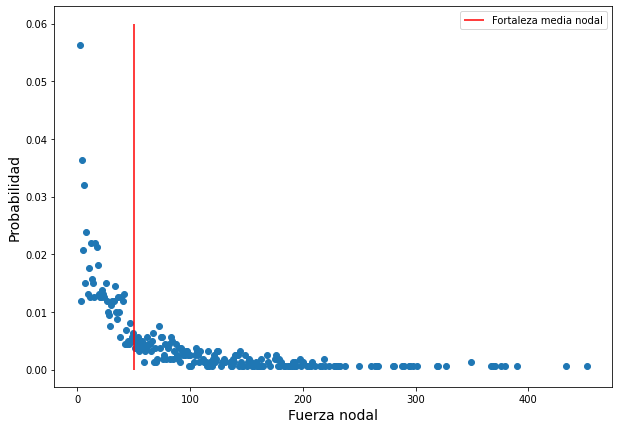

In [183]:
plt.figure(figsize = (10,7))
plt.plot(str_x, str_y/sum(str_y), 'o')
plt.vlines(str_mean, 0, 0.06, color = 'r', label = 'Fortaleza media nodal')
plt.xlabel('Fuerza nodal', fontsize = 14)
plt.ylabel('Probabilidad', fontsize = 14) 
plt.legend()
plt.show()

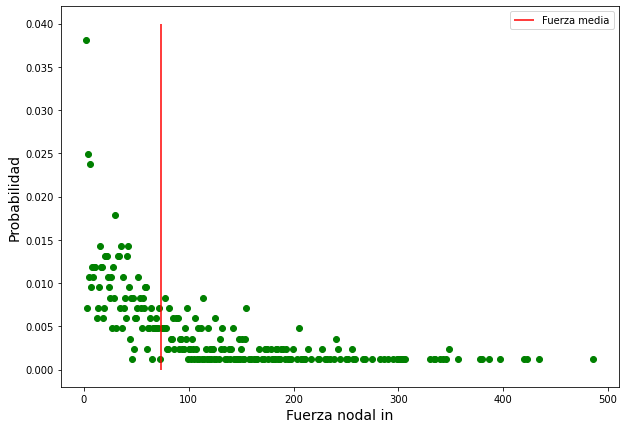

In [178]:
plt.figure(figsize = (10,7))
plt.plot(in_x, in_y/sum(in_y), 'o', color = 'g')
plt.vlines(in_mean, 0, 0.04, color = 'r',label = 'Fuerza media')
plt.xlabel('Fuerza nodal in', fontsize = 14)
plt.ylabel('Probabilidad', fontsize = 14)
plt.legend()

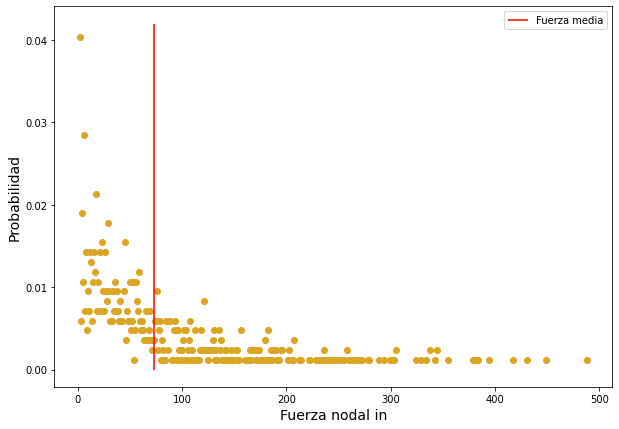

In [180]:
plt.figure(figsize = (10,7))
plt.plot(out_x, out_y/sum(out_y), 'o', color = 'goldenrod')
plt.vlines(in_mean, 0, 0.042, color = 'r',label = 'Fuerza media')
plt.xlabel('Fuerza nodal in', fontsize = 14)
plt.ylabel('Probabilidad', fontsize = 14)
plt.legend()

## Propiedades de la red en funcion del tiempo

En esta seccion se van a estudiar las propiedades pertinentes de la red tales como el grado promedio, la fortaleza nodal, el peso de los arcos en promedio en funcion del tiempo de la misma manera en la que encontre la cantidad de viajes dependiendo de la hora.

### El problema de las ZAT mayoreas a 1000

Existe algo preocupante en la base de datos, y son las zonas de administracion de transporte que su numero de identificacion es mayor a 1000, estas no se encuentran representadas en la base de datos con la que cuento, por lo cual estaba indagando sobre estas zonas, que al parecer se encuentran en las zonas de periferia de Bogota y soacha, como zonas rurales y barrios en la frontera de Bogota, por lo cual es mas dificil localizarlos. Lo normal seria buscar otra base de datos (dificil), o mocharlos.

In [92]:
great_df[great_df['zat_origen'] == 1016][['zat_origen', 'zat_destino', 'utam_origen', 'utam_destino', 'p8v_barrio_vereda', 'mun_origen', 'mun_destino', 'municipio']]

,zat_origen,zat_destino,utam_origen,utam_destino,p8v_barrio_vereda,mun_origen,mun_destino,municipio
9764,1016.0,11.0,UTAM1,UTAM9,NaN,11001.0,11001.0,11001
9768,1016.0,378.0,UTAM1,UTAM43,NaN,11001.0,11001.0,11001
65319,1016.0,657.0,UTAM1,UTAM62,NaN,11001.0,11001.0,11001
66895,1016.0,847.0,UTAM1,UTAM97,NaN,11001.0,11001.0,11001
93910,1016.0,133.0,UTAM1,UTAM24,NaN,11001.0,11001.0,11001
96961,1016.0,9.0,UTAM1,UTAM17,NaN,11001.0,11001.0,11001


In [19]:
great_df.columns

Index(['Unnamed: 0', 'id_hogar', 'Estado', 'Utam', 'Sector', 'Seccion',
       'Manzana', 'p5_fecha', 'p7_Barrio_vivienda', 'Latitud', 'Longitud',
       'zat_hogar', 'p5_estrato', 'p6_hogares_vivienda', 'p7_total_personas',
       'p8_mayores_cinco_anios', 'id_rango_ingresos', 'vivienda', 'Factor',
       'municipio', 'localidad', 'id_persona', 'id_viaje', 'fecha',
       'lugar_origen', 'zat_origen', 'p17_Id_motivo_viaje', 'p17_otro_motivo',
       'hora_inicio_viaje', 'p28_lugar_destino', 'zat_destino',
       'p29_id_municipio', 'p30_camino_cuadras', 'p30_camino_minutos',
       'hora_llegada', 'p32_lunes', 'p32_martes', 'p32_miercoles',
       'p32_jueves', 'p32_viernes', 'p32_sabado', 'p32_domingo',
       'p32_ocasional', 'p36_hora_salida', 'f_exp', 'mun_origen',
       'mun_destino', 'utam_origen', 'utam_destino', 'modo_principal',
       'modo_principal_desagregado', 'duracion', 'p3_id_parentesco_jh',
       'p4_edad', 'p5_id_nivel_educativo', 'p6_id_ocupacion',
       'p6_id_

In [65]:
sorted(great_df[great_df['zat_destino'] > 999]['zat_destino'].unique())

[1001.0,
 1003.0,
 1006.0,
 1008.0,
 1009.0,
 1010.0,
 1011.0,
 1012.0,
 1016.0,
 1017.0,
 1019.0,
 1020.0,
 1021.0,
 1022.0,
 1023.0,
 1024.0,
 1025.0,
 1026.0,
 1028.0,
 1032.0,
 1034.0,
 1035.0,
 1036.0,
 1037.0,
 1038.0,
 1040.0,
 1042.0,
 1043.0,
 1045.0,
 1046.0,
 1047.0,
 1048.0,
 1049.0,
 1050.0,
 1051.0,
 1052.0,
 1054.0,
 1056.0,
 1057.0,
 1059.0,
 1062.0,
 1065.0,
 1066.0,
 1069.0,
 1070.0,
 1071.0,
 1141.0,
 1908.0]

## Series de tiempo

En esta secion se estudiara como cambian las cantidades propias de las redes dependiendo de la hora del dia.

In [10]:
df_time = (great_df[['zat_origen','zat_destino', 'hora_inicio_viaje', 'hora_llegada']]
                    .sort_values(by = ['zat_origen','zat_destino'])
                    .dropna()
                    .reset_index())
df_time['viajes'] = 1
df_time = df_time.drop(columns  = ['index'])
df_time['hora_inicio_viaje'] = to_time(df_time['hora_inicio_viaje'])
df_time['hora_llegada'] = to_time(df_time['hora_llegada'])
df_time

,zat_origen,zat_destino,hora_inicio_viaje,hora_llegada,viajes
0,0.0,0.0,12:45:00,13:00:00,1
1,0.0,60.0,16:30:00,18:00:00,1
2,0.0,66.0,16:20:00,16:25:00,1
3,0.0,85.0,21:30:00,22:30:00,1
4,0.0,93.0,16:00:00,17:00:00,1
...,...,...,...,...,...
105471,1141.0,225.0,18:00:00,18:10:00,1
105472,1141.0,247.0,14:00:00,15:20:00,1
105473,1141.0,252.0,07:00:00,07:15:00,1
105474,1141.0,477.0,15:30:00,16:15:00,1


In [143]:
def make_matrix(df):
    matrix = (df[['zat_origen', 'zat_destino', 'viajes']].drop_duplicates()
                .pivot_table(values = ('viajes'), index = 'zat_origen', columns = 'zat_destino')
                .fillna(0))
    matrix[959] = 0
    matrix[1061] = 0
    matrix.loc[308] = 0
    matrix.loc[478] = 0
    return matrix

In [13]:
df_time[(df_time['hora_inicio_viaje'] < datetime.time(7,0)) & (df_time['hora_llegada'] > datetime.time(7,0))]

,zat_origen,zat_destino,hora_inicio_viaje,hora_llegada,viajes
30,0.0,543.0,06:00:00,08:35:00,1
36,0.0,640.0,06:30:00,07:55:00,1
52,0.0,1051.0,06:30:00,08:12:00,1
224,7.0,1050.0,06:45:00,07:45:00,1
226,7.0,1059.0,06:45:00,07:56:00,1
...,...,...,...,...,...
105198,1050.0,786.0,06:00:00,07:30:00,1
105240,1050.0,1050.0,06:20:00,07:20:00,1
105266,1050.0,1050.0,06:00:00,07:30:00,1
105346,1051.0,1051.0,06:00:00,07:30:00,1


In [144]:
df_time[['zat_origen', 'zat_destino', 'viajes']]

,zat_origen,zat_destino,viajes
0,0.0,0.0,1
1,0.0,60.0,1
2,0.0,66.0,1
3,0.0,85.0,1
4,0.0,93.0,1
...,...,...,...
105471,1141.0,225.0,1
105472,1141.0,247.0,1
105473,1141.0,252.0,1
105474,1141.0,477.0,1


In [78]:
hora1 = datetime.time(0,0)
df_7am = df_time[(df_time['hora_inicio_viaje'] < hora1) & (df_time['hora_llegada'] > hora1)]
matrix_7am = make_matrix(df_7am) 
index7, columns7 = what_index_columns(matrix_7am)
index_columns(matrix_7am, index7, columns7)
#matrix_7am = matrix_7am.to_numpy()
#G_7am = nx.from_numpy_matrix(matrix_7am)

In [102]:
df_time[(df_time['hora_inicio_viaje']  > datetime.time(5,0)) & (df_time['hora_llegada'] < datetime.time(9,0))]

,zat_origen,zat_destino,hora_inicio_viaje,hora_llegada,viajes
17,0.0,298.0,07:00:00,08:00:00,1
29,0.0,509.0,05:30:00,05:40:00,1
30,0.0,543.0,06:00:00,08:35:00,1
34,0.0,621.0,06:00:00,06:30:00,1
36,0.0,640.0,06:30:00,07:55:00,1
...,...,...,...,...,...
105455,1070.0,1017.0,06:30:00,07:00:00,1
105459,1071.0,13.0,06:20:00,06:40:00,1
105461,1071.0,135.0,07:30:00,08:20:00,1
105473,1141.0,252.0,07:00:00,07:15:00,1


In [26]:
2*G_7am.number_of_edges()/(len(G_7am)**2-1)

0.011403839514145009

In [23]:
print(len(G_7am))
print(G_7am.number_of_edges())
print(nx.average_clustering(G_7am))

832
3947
0.04328654977434571


In [145]:
horas = []
meandegree = []
num_nodes = []
num_edges = []
density_ = []
avg_clustering = []

hora = datetime.time(0, 0)
hora_out = datetime.time(22, 0)
hora_in = datetime.time(2,0)
df = df_time[(df_time['hora_inicio_viaje'] >= hora_out) & 
             (df_time['hora_llegada'] <= hora_in) &
             (df_time['hora_inicio_viaje'] <= datetime.time(23, 59)) & 
             (df_time['hora_llegada'] >= hora)]
matrix = make_matrix(df) 
index, columns = what_index_columns(matrix)
index_columns(matrix, index, columns)
matrix = matrix.to_numpy()
G = nx.from_numpy_matrix(matrix)
horas.append(0)
meandegree.append(mean_degree(G))
num_nodes.append(len(G))
num_edges.append(G.number_of_edges())
density_.append(density(G))
avg_clustering.append(nx.average_clustering(G))

for i in range(1,24):
    hora = datetime.time(i, 0)
    df = df_time[(df_time['hora_inicio_viaje'] <= hora) & (df_time['hora_llegada'] >= hora)]
    matrix = make_matrix(df) 
    index, columns = what_index_columns(matrix)
    index_columns(matrix, index, columns)
    matrix = matrix.to_numpy()
    G = nx.from_numpy_matrix(matrix)
    horas.append(i)
    meandegree.append(mean_degree(G))
    num_nodes.append(len(G))
    num_edges.append(G.number_of_edges())
    density_.append(density(G))
    avg_clustering.append(nx.average_clustering(G))
    del G
    del df
    del matrix

[]

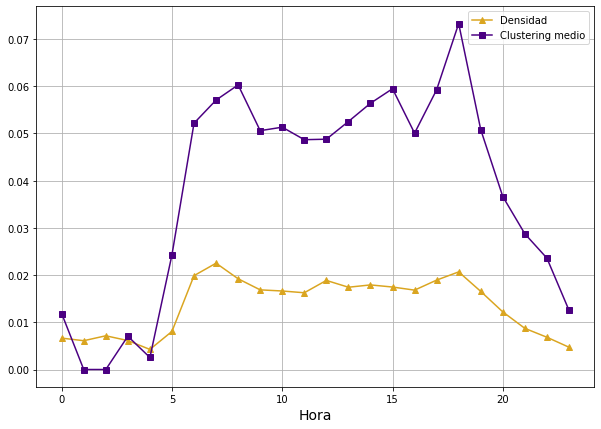

In [147]:
plt.figure(figsize = (10, 7))
#plt.plot(horas, meandegree, 'o', linestyle = '-', label = 'Grado medio')
#plt.plot(horas, num_nodes, '*', color = 'r', linestyle = '-', label = 'Nodos en la red')
#plt.plot(horas, num_edges, 'v', color = 'g', linestyle = '-', label = 'Conexiones en la red')
plt.plot(horas, density_, '^', color = 'goldenrod', linestyle = '-', label = 'Densidad')
plt.plot(horas, avg_clustering, 's', color = 'indigo', linestyle = '-', label = 'Clustering medio')
plt.xlabel('Hora', fontsize = 14)
plt.legend()
plt.grid()
plt.plot()

[]

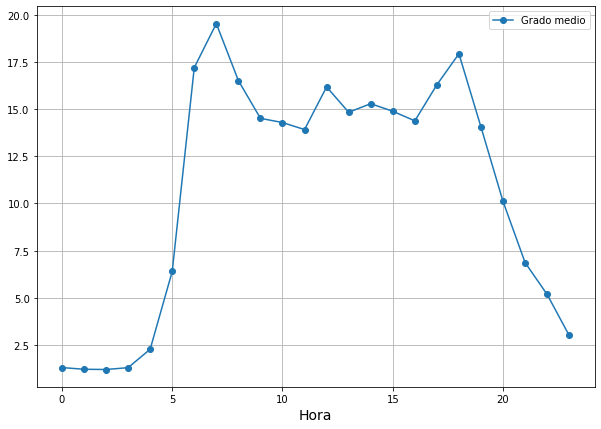

In [146]:
plt.figure(figsize = (10, 7))
plt.plot(horas, meandegree, 'o', linestyle = '-', label = 'Grado medio')
#plt.plot(horas, num_nodes, '*', color = 'r', linestyle = '-', label = 'Nodos en la red')
#plt.plot(horas, num_edges, 'v', color = 'g', linestyle = '-', label = 'Conexiones en la red')
#plt.plot(horas, density_, '^', color = 'goldenrod', linestyle = '-', label = 'Densidad')
#plt.plot(horas, avg_clustering, 's', color = 'indigo', linestyle = '-', label = 'Clustering medio')
plt.xlabel('Hora', fontsize = 14)
plt.legend()
plt.grid()
plt.plot()

[]

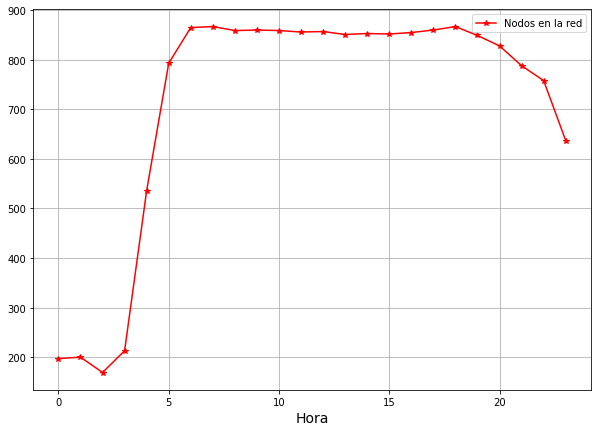

In [148]:
plt.figure(figsize = (10, 7))
#plt.plot(horas, meandegree, 'o', linestyle = '-', label = 'Grado medio')
plt.plot(horas, num_nodes, '*', color = 'r', linestyle = '-', label = 'Nodos en la red')
#plt.plot(horas, num_edges, 'v', color = 'g', linestyle = '-', label = 'Conexiones en la red')
#plt.plot(horas, density_, '^', color = 'goldenrod', linestyle = '-', label = 'Densidad')
#plt.plot(horas, avg_clustering, 's', color = 'indigo', linestyle = '-', label = 'Clustering medio')
plt.xlabel('Hora', fontsize = 14)
plt.legend()
plt.grid()
plt.plot()

[]

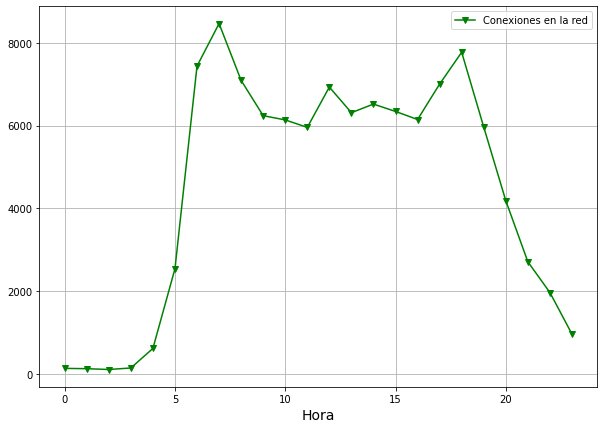

In [149]:
plt.figure(figsize = (10, 7))
#plt.plot(horas, meandegree, 'o', linestyle = '-', label = 'Grado medio')
#plt.plot(horas, num_nodes, '*', color = 'r', linestyle = '-', label = 'Nodos en la red')
plt.plot(horas, num_edges, 'v', color = 'g', linestyle = '-', label = 'Conexiones en la red')
#plt.plot(horas, density_, '^', color = 'goldenrod', linestyle = '-', label = 'Densidad')
#plt.plot(horas, avg_clustering, 's', color = 'indigo', linestyle = '-', label = 'Clustering medio')
plt.xlabel('Hora', fontsize = 14)
plt.legend()
plt.grid()
plt.plot()

Como se puede ver en todos los parametros estudiados, la red de movilidad puede tomarse como una red dinamica en la cual, dependiendo de la hora del dia, el sistema cambia su estructura, al menos para el caso del grado, de una manera muy similar a como cambia el numero de viajes realizados a una determinada hora, de hecho ambas graficas son muy similares, con ligeras diferencias en la manera de como crece el numero de viajes y el grado promedio de la red, pero si se nota que un mayor grado coincide con las horas pico. Algo interesante es la cantidad de nodos en la red, la cual se mantiene constante entre 6 AM y 6 PM, donde comienza a decender.

## Prueba de Newman 

Aca se hara una prueba del algoritmo de newman 

In [152]:
array = [1,4,8,2,46,4,95,1,5,84,1,7,9,2,65,3,7]
array_nw = []
for i in range(len(array)):
    suma = sum(array[i:])
    array_nw.append(suma)

[344, 343, 339, 331, 329, 283, 279, 184, 183, 178, 94, 93, 86, 77, 75, 10, 7]

## Proximamente

Calcular la entropia del grado y de cada propiedad que se me pase por delante :v

Revisar a profundidad la naturaleza de las redes, al menos algo de lo que estoy seguro es que los grados estan bien XD.

Calcular y sacar las propiedades de las redes en funcion del tiempo.

## Importante 

Que constantes pueden mantenerse en algo tan dinamico como lo es la movilidad en una ciudad, encontrar cantidades conservadas podria dar mucha informacion de como se comporta el sistema, y pues aja, son muchos los sistemas que su resolucion se basa en encontrar cantidades conservadas. El hecho de que las distribuciones de grado sean leyes exponenciales (al parecer :v) dan razon de que si existen estas cantidades.